In [1]:
#Preprocessing functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.1 MB/s eta 0:00:00


In [3]:
import cv2

In [4]:
#Loading Dataset:
!pip install -q kaggle


In [9]:
#then move the .zip file into drive from /content
#!cp /content/chest-xray-masks-and-labels.zip /content/drive/MyDrive

In [5]:
%mkdir dataset
%mkdir dataset/images # for source images
%mkdir dataset/masks # for annotation masks
%mkdir dataset/test # for test images
%mkdir dataset/temp # temp storage


In [6]:
# start the download, get from google drive
#!kaggle datasets download 'nikhilpandey360/chest-xray-masks-and-labels'

In [7]:
#move the zip file to my google drive
#first mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#get the zip file from the drive, download
!cp /content/drive/MyDrive/chexmasks.zip /content/dataset.zip

In [10]:
!unzip dataset.zip -d dataset/temp/

Archive:  dataset.zip
  inflating: dataset/temp/Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0011_0.png  
  inflating: dataset/temp/Lung Segmentation/CXR_png/CHNCXR_0012_0.png  
  inflating: dataset/

In [11]:
%ls dataset/temp/Lung\ Segmentation

ClinicalReadings/  masks/                       NLM-MontgomeryCXRSet-ReadMe.pdf
CXR_png/           NLM-ChinaCXRSet-ReadMe.docx  test/


In [12]:
%mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/images/
IMAGE_PATH = "/content/dataset/images/"

In [13]:
%mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/masks/
MASK_PATH = '/content/dataset/masks/'
%mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/test/
TEST_PATH = '/content/dataset/test/'

mv: cannot stat 'dataset/temp/Lung Segmentation/CXR_png/*': No such file or directory
mv: cannot stat 'dataset/temp/Lung Segmentation/CXR_png/*': No such file or directory


In [14]:
%mkdir /content/transformed_images

In [15]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

image_dir = '/content/dataset/images'  # Path to your images folder
output_dir = '/content/dataset/transformed_images'  # Where to save the transformed components
os.makedirs(output_dir, exist_ok=True)

num=40

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])[:num]

In [16]:
%mv dataset/temp/Lung\ Segmentation/masks/* dataset/masks/
MASK_PATH = '/content/dataset/masks/'

In [17]:
MASK_PATH = '/content/dataset/masks/'
TEST_PATH = '/content/dataset/test/'

In [18]:
# importing os module
import os

# suffix cropping function
def rchop(s, suffix):
    if suffix and s.endswith(suffix):
        return s[:-len(suffix)]
    return s

suffix = "_mask.png"

# iterate over all mask images and edit the file-names
for count, filename in enumerate(os.listdir("/content/dataset/masks")):
  src = "/content/dataset/masks/" + filename
  res = rchop(src, suffix)
  dst = ""
  if src != res:
    dst = rchop(src, suffix) + ".png"
    os.rename(src, dst)

In [19]:
# check the number of files in the images/ and masks/ directories
import os.path

print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))


number of files in images/ directory: 800
number of files in masks/ directory: 704


In [20]:
# function to confirm the existence of a file in a given directory
def searchFile(fileName, TARGET_PATH):
  for root, dirs, files in os.walk(TARGET_PATH):
    for Files in files:
      #print(Files)
      found = Files.find(fileName)
      if found != -1:
        break
  return found

In [21]:
%mkdir /content/dataset/orphan_images

In [22]:
# clean up the images/ directory by removing all images that do not have a mask
import shutil

cnt = 0

for count, filename in enumerate(os.listdir("/content/dataset/images")):
  found = searchFile(filename, MASK_PATH)
  if found == -1:
    cnt = cnt + 1
    src = "/content/dataset/images/" + filename
    dst = "/content/dataset/orphan_images/" + filename
    dest = shutil.move(src, dst)
print("number of files not matched: " + str(cnt))

number of files not matched: 96


In [23]:
# confirm consistency
print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))

number of files in images/ directory: 704
number of files in masks/ directory: 704


Make proper accurate splits of data

In [24]:
import os
import shutil
import random

# Assuming the previous code has already been executed, and the following directories are set up:
IMAGE_PATH = '/content/dataset/images/'
MASK_PATH = '/content/dataset/masks/'
TEST_PATH = '/content/dataset/test/'

# Create the test directory if it doesn't exist
os.makedirs(TEST_PATH, exist_ok=True)

# Get all image filenames
all_images = sorted([f for f in os.listdir(IMAGE_PATH) if f.endswith('.png')])

# Calculate 10% for the test split
num_test = int(len(all_images) * 0.1)

# Randomly select 10% of the dataset for testing
test_indices = random.sample(range(len(all_images)), num_test)

# Move selected images to the test directory
for idx in test_indices:
    src = os.path.join(IMAGE_PATH, all_images[idx])
    dst = os.path.join(TEST_PATH, all_images[idx])
    shutil.move(src, dst)

print(f"Moved {num_test} images to the test directory: {TEST_PATH}")

# Check the number of files in the test directory
print("Number of files in the test directory: " + str(len(os.listdir(TEST_PATH))))

Moved 70 images to the test directory: /content/dataset/test/
Number of files in the test directory: 70


In [25]:
# Create the test_masks directory if it doesn't exist
TEST_MASKS_PATH = '/content/dataset/test_masks/'
os.makedirs(TEST_MASKS_PATH, exist_ok=True)

# Move corresponding masks to the test_masks directory
for idx in test_indices:
    # Get the filename of the image that was moved
    image_filename = all_images[idx]

    # The mask filename is the same as the image filename
    mask_filename = image_filename  # No changes needed to the filename
    src_mask = os.path.join(MASK_PATH, mask_filename)

    # Print debug information
    print(f"Checking for mask: {mask_filename}")
    print(f"Source mask path: {src_mask}")

    # Check if the corresponding mask exists before moving
    if os.path.exists(src_mask):
        dst_mask = os.path.join(TEST_MASKS_PATH, mask_filename)
        shutil.move(src_mask, dst_mask)
    else:
        print(f"Mask not found for image: {image_filename}")

# Check the number of files in the test_masks directory
print("Number of masks in the test_masks directory: " + str(len(os.listdir(TEST_MASKS_PATH))))

Checking for mask: CHNCXR_0636_1.png
Source mask path: /content/dataset/masks/CHNCXR_0636_1.png
Checking for mask: CHNCXR_0340_1.png
Source mask path: /content/dataset/masks/CHNCXR_0340_1.png
Checking for mask: MCUCXR_0104_1.png
Source mask path: /content/dataset/masks/MCUCXR_0104_1.png
Checking for mask: CHNCXR_0289_0.png
Source mask path: /content/dataset/masks/CHNCXR_0289_0.png
Checking for mask: CHNCXR_0132_0.png
Source mask path: /content/dataset/masks/CHNCXR_0132_0.png
Checking for mask: CHNCXR_0556_1.png
Source mask path: /content/dataset/masks/CHNCXR_0556_1.png
Checking for mask: MCUCXR_0255_1.png
Source mask path: /content/dataset/masks/MCUCXR_0255_1.png
Checking for mask: CHNCXR_0405_1.png
Source mask path: /content/dataset/masks/CHNCXR_0405_1.png
Checking for mask: CHNCXR_0177_0.png
Source mask path: /content/dataset/masks/CHNCXR_0177_0.png
Checking for mask: CHNCXR_0224_0.png
Source mask path: /content/dataset/masks/CHNCXR_0224_0.png
Checking for mask: MCUCXR_0051_0.png
Sou

In [26]:
print("Number of files in the mask directory: " + str(len(os.listdir(MASK_PATH))))
print("Number of files in the train_image directory: " + str(len(os.listdir(IMAGE_PATH))))

Number of files in the mask directory: 634
Number of files in the train_image directory: 634


Testing PyWavelet Transformations

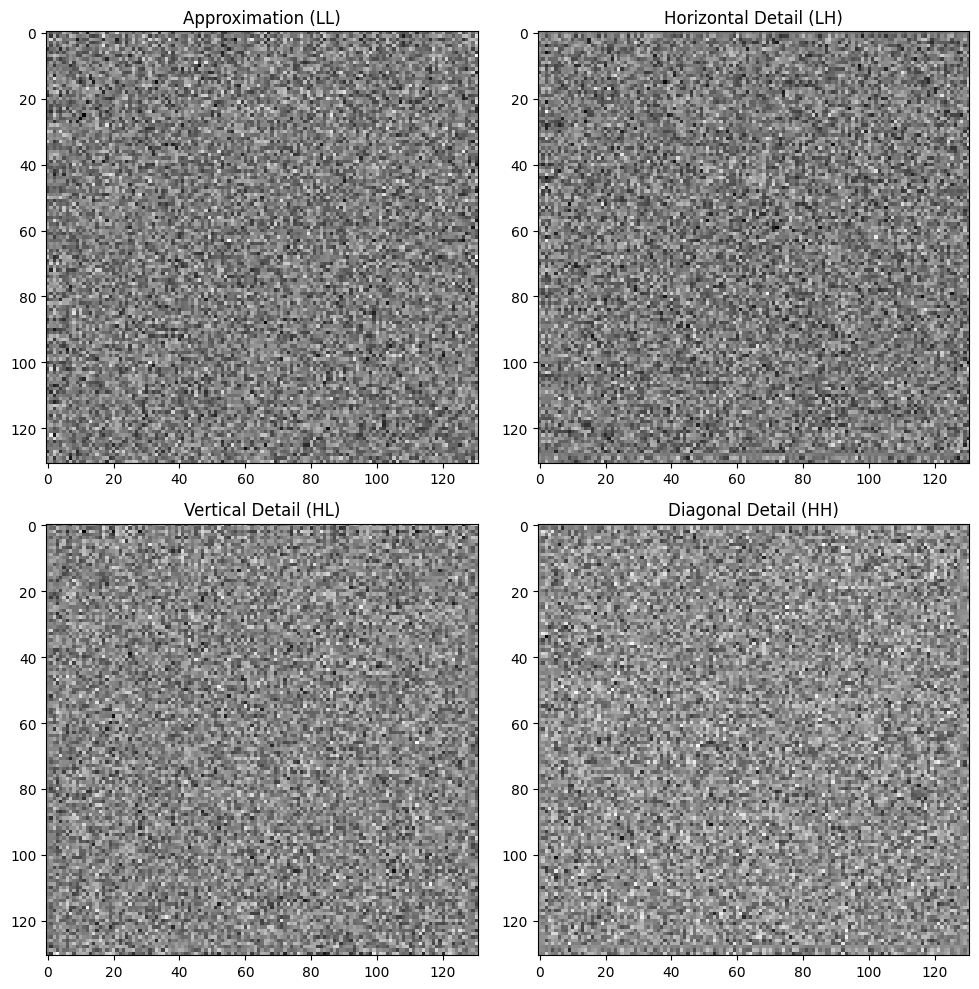

In [27]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample 2D array (image-like) for demonstration
data = np.random.rand(256, 256)

# Perform 2D Discrete Wavelet Transform using the Daubechies 4 (db4) wavelet
coeffs2 = pywt.dwt2(data, 'db4')

# The result of dwt2 is a tuple containing (LL, (LH, HL, HH))
LL, (LH, HL, HH) = coeffs2

# Plot the original and transformed coefficients
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(LL, cmap='gray')
plt.title('Approximation (LL)')

plt.subplot(2, 2, 2)
plt.imshow(LH, cmap='gray')
plt.title('Horizontal Detail (LH)')

plt.subplot(2, 2, 3)
plt.imshow(HL, cmap='gray')
plt.title('Vertical Detail (HL)')

plt.subplot(2, 2, 4)
plt.imshow(HH, cmap='gray')
plt.title('Diagonal Detail (HH)')

plt.tight_layout()
plt.show()

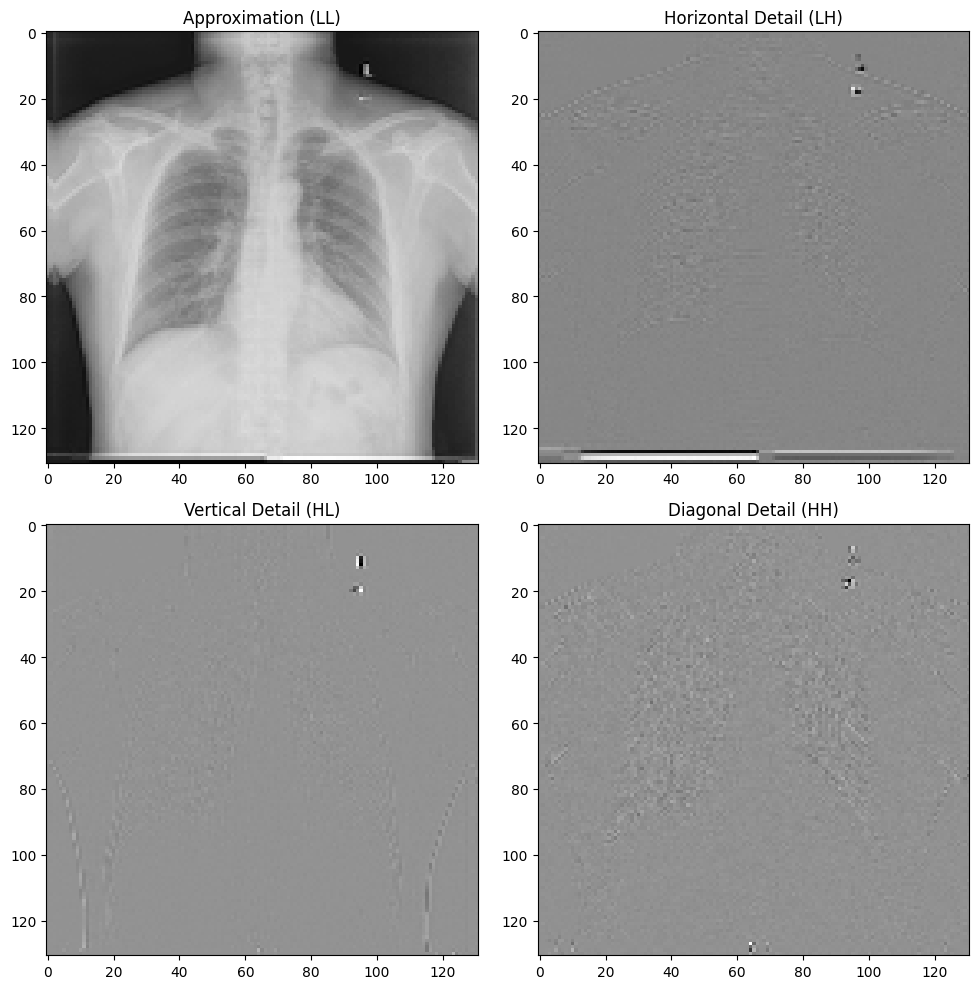

In [28]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Function to load and preprocess image
def load_image(image_path):
    # Load the image in grayscale mode
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize image to 256x256 (if needed)
    img = cv2.resize(img, (256, 256))

    # Normalize the image data (optional but helps with numerical stability)
    img = img / 255.0

    return img

# Function to perform 2D wavelet transform and plot components
def perform_wavelet_transform(image):
    # Perform 2D Discrete Wavelet Transform using the Daubechies 4 (db4) wavelet
    coeffs2 = pywt.dwt2(image, 'db4')

    # The result of dwt2 is a tuple containing (LL, (LH, HL, HH))
    LL, (LH, HL, HH) = coeffs2

    # Plot the original and transformed coefficients
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(LL, cmap='gray')
    plt.title('Approximation (LL)')

    plt.subplot(2, 2, 2)
    plt.imshow(LH, cmap='gray')
    plt.title('Horizontal Detail (LH)')

    plt.subplot(2, 2, 3)
    plt.imshow(HL, cmap='gray')
    plt.title('Vertical Detail (HL)')

    plt.subplot(2, 2, 4)
    plt.imshow(HH, cmap='gray')
    plt.title('Diagonal Detail (HH)')

    plt.tight_layout()
    plt.show()

# TEst images in our dataset
image_path = '/content/dataset/images/CHNCXR_0002_0.png'

# Load the image
image = load_image(image_path)

# Perform wavelet transform and plot the components
perform_wavelet_transform(image)


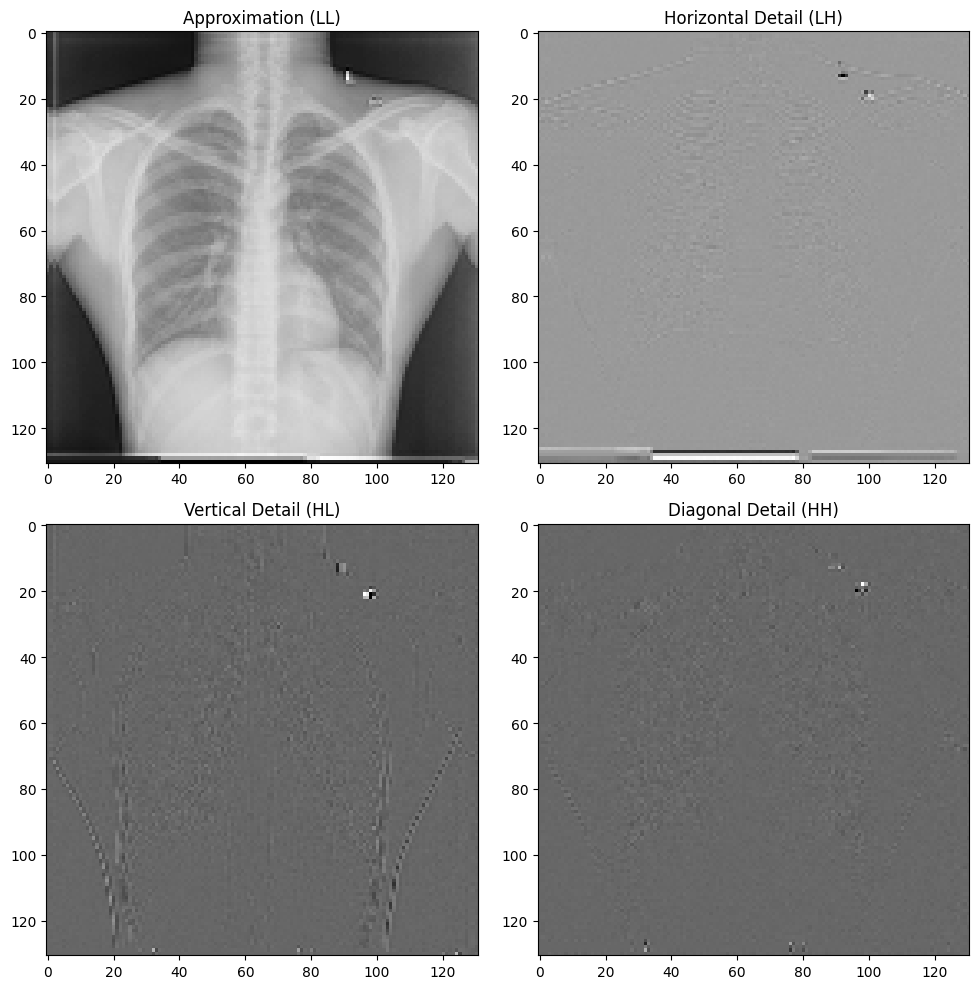

In [29]:
# Test images in our dataset
image_path = '/content/dataset/images/CHNCXR_0005_0.png'

# Load the image
image = load_image(image_path)

# Perform wavelet transform and plot the components
perform_wavelet_transform(image)

**Data Generator:**

In [30]:
# import os
# import numpy as np
# import pywt
# import cv2
# import tensorflow as tf

# # Custom Data Generator class
# class WaveletDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, image_folder, mask_folder, batch_size, image_size=(256, 256), wavelet='db4'):
#         self.image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)]
#         self.mask_paths = [os.path.join(mask_folder, fname) for fname in os.listdir(mask_folder)]
#         self.batch_size = batch_size
#         self.image_size = image_size
#         self.wavelet = wavelet

#     def __len__(self):
#         return int(np.floor(len(self.image_paths) / self.batch_size))

#     def __getitem__(self, index):
#         # Generate batch indexes
#         batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
#         batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]

#         # Initialize arrays for the batch
#         images = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], 4))  # 4 channels for LL, LH, HL, HH
#         masks = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], 1))   # Single-channel mask

#         for i, (img_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
#             # Load image and mask
#             img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#             if img is None:
#                 raise ValueError(f"Error loading image from {img_path}")
#             img = cv2.resize(img, self.image_size) / 255.0  # Normalize image

#             mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#             if mask is None:
#                 raise ValueError(f"Error loading mask from {mask_path}")
#             mask = cv2.resize(mask, self.image_size) / 255.0  # Normalize mask
#             mask = np.expand_dims(mask, axis=-1)  # Add channel dimension for mask

#             # Perform wavelet transformation
#             coeffs2 = pywt.dwt2(img, self.wavelet)
#             LL, (LH, HL, HH) = coeffs2

#             # Stack the components into a 4-channel image and resize to the original size
#             wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)  # Shape: smaller than (256, 256, 4)
#             wavelet_image = cv2.resize(wavelet_image, self.image_size)  # Resize to (256, 256, 4)

#             # Add to batch
#             images[i] = wavelet_image
#             masks[i] = mask

#         return images, masks

# # Example usage:
# image_folder = IMAGE_PATH  # Replace with actual folder path
# mask_folder = MASK_PATH    # Replace with actual folder path
# batch_size = 4

# data_gen = WaveletDataGenerator(image_folder, mask_folder, batch_size)

# # Get a sample batch
# sample_images, sample_masks = data_gen[0]

# print("Batch shape (images):", sample_images.shape)  # Should be (batch_size, 256, 256, 4)
# print("Batch shape (masks):", sample_masks.shape)    # Should be (batch_size, 256, 256, 1)
import os
import numpy as np
import pywt
import cv2
import tensorflow as tf

class WaveletDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_folder, mask_folder, file_list, batch_size, image_size=(256, 256), wavelet='db4'):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.file_list = file_list
        self.batch_size = batch_size
        self.image_size = image_size
        self.wavelet = wavelet

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_list[index * self.batch_size:(index + 1) * self.batch_size]

        images = np.zeros((len(batch_files), self.image_size[0], self.image_size[1], 4))
        masks = np.zeros((len(batch_files), self.image_size[0], self.image_size[1], 1))

        for i, filename in enumerate(batch_files):
            img_path = os.path.join(self.image_folder, filename)
            mask_path = os.path.join(self.mask_folder, filename)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Error loading image from {img_path}")
            img = cv2.resize(img, self.image_size) / 255.0

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise ValueError(f"Error loading mask from {mask_path}")
            mask = cv2.resize(mask, self.image_size) / 255.0
            mask = np.expand_dims(mask, axis=-1)

            coeffs2 = pywt.dwt2(img, self.wavelet)
            LL, (LH, HL, HH) = coeffs2

            wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)
            wavelet_image = cv2.resize(wavelet_image, self.image_size)

            images[i] = wavelet_image
            masks[i] = mask

        return images, masks

Test Data generator:

In [34]:
# import matplotlib.pyplot as plt
# import numpy as np

# def visualize_wavelet_components(data_gen, num_samples=5):
#     fig, axes = plt.subplots(num_samples, 5, figsize=(25, 5*num_samples))
#     titles = ['Original', 'LL', 'LH', 'HL', 'HH']

#     for i in range(num_samples):
#         # Get a sample image
#         sample_image, sample_mask = data_gen[np.random.randint(len(data_gen))]

#         # The original image can be approximated by the LL component
#         original = sample_image[0, :, :, 0]  # LL component

#         # Plot original image (approximated by LL)
#         axes[i, 0].imshow(original, cmap='gray')
#         axes[i, 0].set_title(f'Sample {i+1}: {titles[0]}')
#         axes[i, 0].axis('off')

#         # Plot wavelet components
#         for j in range(4):
#             axes[i, j+1].imshow(sample_image[0, :, :, j], cmap='gray')
#             axes[i, j+1].set_title(f'Sample {i+1}: {titles[j+1]}')
#             axes[i, j+1].axis('off')

#     plt.tight_layout()
#     plt.show()

# test_data_gen = WaveletDataGenerator(IMAGE_PATH,MASK_PATH)

# # Visualize wavelet components for 5 random samples
# visualize_wavelet_components(test_data_gen, num_samples=5)

**UNET MODEL:**

In [35]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

# Modify input shape to (256, 256, 4) for wavelet-transformed images
model = build_unet((256, 256, 4))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [39]:
# Print the model summary to confirm the architecture
model.summary()
batch_size=4

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          2,368 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,873 (118.47 MB)

 Trainable params: 31,044,097 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

**TRAINING THE MODEL:**

In [41]:
# #have to define validation set for val_accuracy
# #Working on a new training of model using Early stop and validation accuracy
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from sklearn.model_selection import train_test_split

# # 1. Split data into training and validation sets (assuming filenames are the same in both folders)
# image_files = os.listdir(IMAGE_PATH)
# mask_files = os.listdir(MASK_PATH)

# train_images, val_images, train_masks, val_masks = train_test_split(
#     image_files, mask_files, test_size=0.2, random_state=42
# )

# # 2. Update the data generator to work with filenames split
# train_data_gen = WaveletDataGenerator(
#     image_folder=IMAGE_PATH,
#     mask_folder=MASK_PATH,
#     batch_size=batch_size
# )

# val_data_gen = WaveletDataGenerator(
#     image_folder=IMAGE_PATH,
#     mask_folder=MASK_PATH,
#     batch_size=batch_size
# )

In [42]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Split data
image_files = os.listdir(IMAGE_PATH)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Create data generators
train_data_gen = WaveletDataGenerator(
    image_folder=IMAGE_PATH,
    mask_folder=MASK_PATH,
    file_list=train_files,
    batch_size=batch_size
)

val_data_gen = WaveletDataGenerator(
    image_folder=IMAGE_PATH,
    mask_folder=MASK_PATH,
    file_list=val_files,
    batch_size=batch_size
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Save the final model
model.save("final_model.h5")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.8320 - loss: 0.3878 - val_accuracy: 0.7106 - val_loss: 0.5705
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 172s 981ms/step - accuracy: 0.9726 - loss: 0.1150 - val_accuracy: 0.7449 - val_loss: 0.6769
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9778 - loss: 0.0902 - val_accuracy: 0.7721 - val_loss: 0.6389
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9789 - loss: 0.0802 - val_accuracy: 0.8745 - val_loss: 0.3266
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 135s 962ms/step - accuracy: 0.9790 - loss: 0.0748 - val_accuracy: 0.9771 - val_loss: 0.0756
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9810 - loss: 0.0652 - val_accuracy: 0.9795 - val_loss: 0.0667
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 125s 938ms/step - accuracy: 0.9820 - loss: 0.0594 - val_accuracy: 0.9692 - val_loss: 0.0905
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 145s 976ms/step - accuracy: 0.9797 - loss: 0.0633 - val_acc

In [38]:
# # Early stopping callback with patience of 4 epochs
# early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# # Model checkpoint to save the best model
# model_checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
# validation_steps=len(val_images)
# # Train the model with validation data
# history = model.fit(
#     train_data_gen,
#     validation_data=val_data_gen,
#     epochs=7,
#     steps_per_epoch=len(train_data_gen),
#     #validation_steps=validation_steps,
#     callbacks=[early_stopping, model_checkpoint],
#     verbose=2  # More detailed logging
# )

# # Save the model after training
# model.save("pywavelettedUnet.h5")

Epoch 1/7
158/158 - 230s - 1s/step - accuracy: 0.9809 - loss: 0.0584 - val_accuracy: 0.9811 - val_loss: 0.0584
Epoch 2/7
158/158 - 108s - 684ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9811 - val_loss: 0.0584
Epoch 3/7
158/158 - 228s - 1s/step - accuracy: 0.9799 - loss: 0.0590 - val_accuracy: 0.9816 - val_loss: 0.0551
Epoch 4/7


KeyboardInterrupt: 

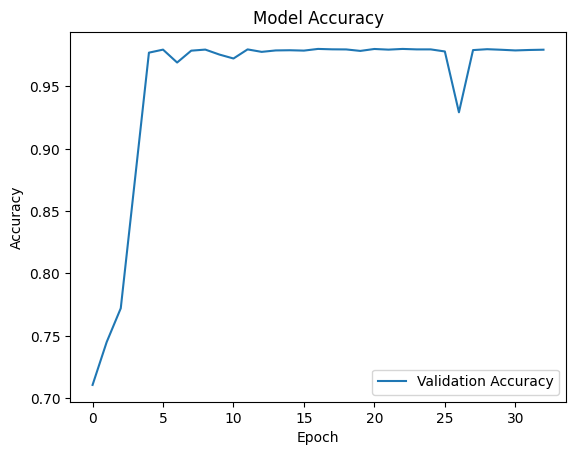

In [43]:
# Train the model for
# Plotting training accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

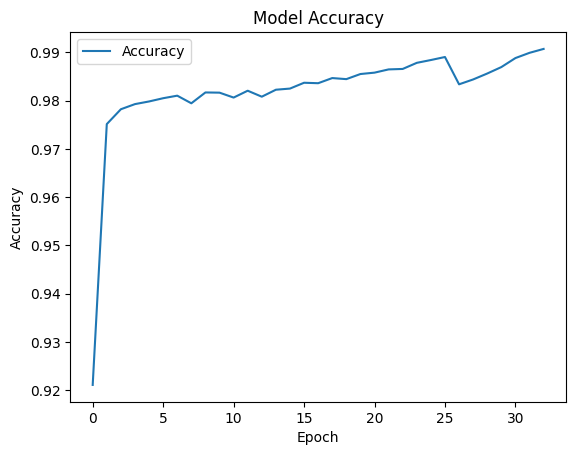

In [44]:
# Train the model for
# Plotting training accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [45]:
#test on a few images:

Preprocessed image shape: (1, 256, 256, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


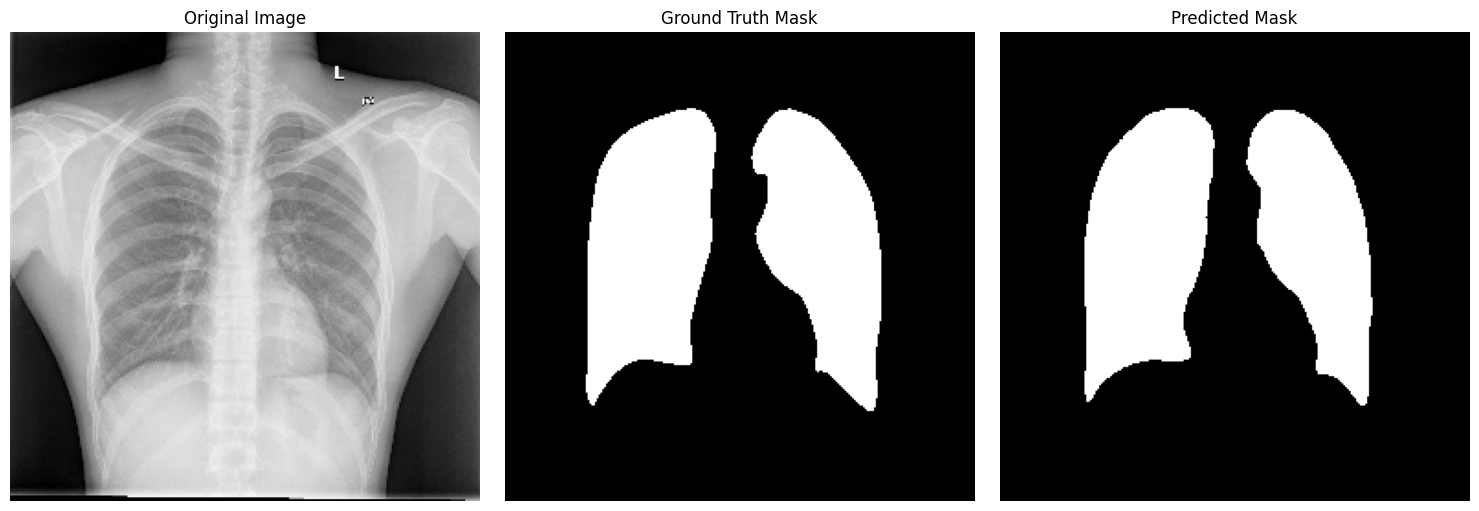

Accuracy: 0.9796
F1 Score: 0.9560


In [47]:
import numpy as np
import cv2
import os
import pywt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
def load_and_preprocess_image(image_path, wavelet='db4', image_size=(256, 256)):
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    img_resized = cv2.resize(img, image_size) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)

    if coeffs2 is None or len(coeffs2) != 2:
        raise ValueError("Wavelet transformation failed to produce coefficients.")

    LL, (LH, HL, HH) = coeffs2

    LL = cv2.resize(LL, image_size)
    LH = cv2.resize(LH, image_size)
    HL = cv2.resize(HL, image_size)
    HH = cv2.resize(HH, image_size)

    wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)

    return img_resized, wavelet_image


# Load and preprocess the image
image_path = "/content/dataset/images/CHNCXR_0005_0.png"  # Replace with your actual image path
mask_path = "/content/dataset/masks/CHNCXR_0005_0.png" # Replace with your actual mask path



def load_ground_truth_mask(mask_path, image_size=(256, 256)):
    if not os.path.exists(mask_path):
        raise ValueError(f"Ground truth mask not found: {mask_path}")

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Ground truth mask could not be loaded: {mask_path}")

    mask_resized = cv2.resize(mask, image_size)
    # Ensure the mask is binary
    mask_binary = (mask_resized > 127).astype(np.uint8)
    return mask_binary

original_image, preprocessed_image = load_and_preprocess_image(image_path)
ground_truth_mask = load_ground_truth_mask(mask_path)

# Add a batch dimension for model prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

print(f"Preprocessed image shape: {preprocessed_image_batch.shape}")

# Make prediction
predicted_mask = model.predict(preprocessed_image_batch)

# Ensure the predicted mask is binary
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(ground_truth_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

axes[2].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Calculate and print metrics
predicted_flat = predicted_mask_binary[0, :, :, 0].flatten()
ground_truth_flat = ground_truth_mask.flatten()

accuracy = accuracy_score(ground_truth_flat, predicted_flat)
f1 = f1_score(ground_truth_flat, predicted_flat)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

**MODEL Metrics**

In [48]:
from sklearn.metrics import jaccard_score, f1_score

def compute_metrics(model, data_gen):
    y_true = []
    y_pred = []

    for i in range(len(data_gen)):
        images, masks = data_gen[i]
        preds = model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)  # Threshold predictions

        # Flatten and convert masks to binary if they aren't already
        y_true.append((masks > 0.5).astype(np.uint8).flatten())  # Ensure y_true is binary
        y_pred.append(preds.flatten())

    # Convert lists to arrays
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Calculate IoU
    iou = jaccard_score(y_true, y_pred, average='binary')

    # Calculate Dice Coefficient
    dice = f1_score(y_true, y_pred)

    return iou, dice

# Usage
iou, dice = compute_metrics(model, val_data_gen)
print("Val IoU:", iou)
print("Val Dice Coefficient:", dice)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

In [49]:
#save model:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
model.save('/content/drive/MyDrive/pywavelettedUnet.h5')

In [56]:
import os
import numpy as np
from sklearn.metrics import jaccard_score, f1_score
import cv2
import pywt

class TestWaveletDataGenerator:
    def __init__(self, image_folder, mask_folder, image_size=(256, 256), wavelet='db4'):
        self.image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder)])
        self.mask_paths = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder)])
        self.image_size = image_size
        self.wavelet = wavelet

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.image_size) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.image_size) / 255.0
        mask = np.expand_dims(mask, axis=-1)

        coeffs2 = pywt.dwt2(img, self.wavelet)
        LL, (LH, HL, HH) = coeffs2

        wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)
        wavelet_image = cv2.resize(wavelet_image, self.image_size)

        return np.expand_dims(wavelet_image, axis=0), np.expand_dims(mask, axis=0)

def compute_metrics(model, data_gen, batch_size=32):
    y_true = []
    y_pred = []

    for i in range(len(data_gen)):
        print(f"Processing image {i+1}/{len(data_gen)}")

        image, mask = data_gen[i]
        pred = model.predict(image)
        pred = (pred > 0.5).astype(np.uint8)

        y_true.append((mask > 0.5).astype(np.uint8).flatten())
        y_pred.append(pred.flatten())

        if len(y_true) == batch_size or i == len(data_gen) - 1:
            y_true_batch = np.concatenate(y_true)
            y_pred_batch = np.concatenate(y_pred)

            if i == len(data_gen) - 1:
                # Final batch, compute and return metrics
                iou = jaccard_score(y_true_batch, y_pred_batch, average='binary')
                dice = f1_score(y_true_batch, y_pred_batch, average='binary')
                return iou, dice
            else:
                # Reset lists for next batch
                y_true = []
                y_pred = []

    # This should not be reached
    return None, None

# Usage
TEST_IMAGE_PATH = "/content/dataset/test"
TEST_MASK_PATH = "/content/dataset/test_masks"

test_data_gen = TestWaveletDataGenerator(TEST_IMAGE_PATH, TEST_MASK_PATH)

iou, dice = compute_metrics(model, test_data_gen)
print("Test IoU:", iou)
print("Test Dice Coefficient:", dice)

Processing image 1/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Processing image 2/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Processing image 3/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Processing image 4/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Processing image 5/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Processing image 6/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Processing image 7/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Processing image 8/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Processing image 9/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Processing image 10/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Processing image 11/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Processing image 12/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Processing image 13/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Processing image 14/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Processing image 15/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Processing image 16/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Processing image 17/70
1/1 ━━━━━━